Saved cluster assignments to country_clusters.csv
Chose k=3. PCA variance explained: 0.37, 0.09


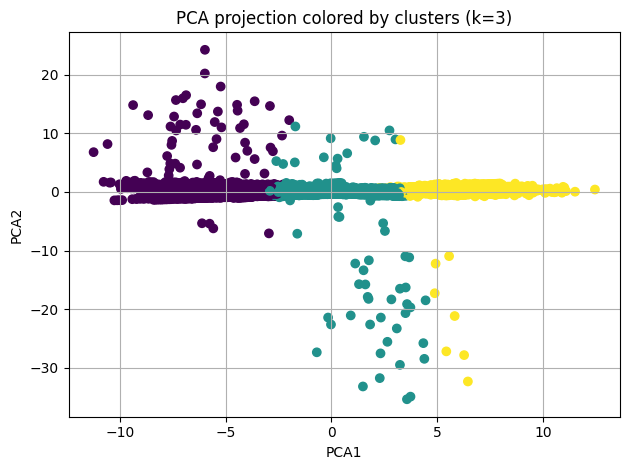

In [ ]:
 # clustering_countries.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# ---- 1) Load data ----
df = pd.read_excel("data.xlsx")  # put data.xlsx in the same folder
df = df.drop('year', axis=1)

# Try to find a country/name column for labeling
possible_name_cols = [c for c in df.columns if str(c).lower() in ["country","country_name","name","nation"]]
name_col = possible_name_cols[0] if possible_name_cols else (df.columns[0] if not pd.api.types.is_numeric_dtype(df.iloc[:,0]) else None)

# ---- 2) Select numeric features ----
X_num = df.select_dtypes(include=[np.number]).copy()
if X_num.shape[1] == 0:
    raise ValueError("No numeric columns were found for clustering.")

# ---- 3) Impute + scale ----
imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X_num.values)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# ---- 4) Pick k quickly via a tiny elbow rule ----
def pick_k_by_elbow(X, ks=(2,3,4,5,6)):
    inertias = []
    for k in ks:
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        km.fit(X)
        inertias.append(km.inertia_)
    drops = [(inertias[i-1]-inertias[i])/inertias[i-1] for i in range(1,len(inertias))]
    if drops:
        best_idx = int(np.argmax(drops)) + 1  # index into ks
        return ks[best_idx]
    return ks[0]

k = pick_k_by_elbow(X_scaled)

# ---- 5) Fit KMeans ----
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# ---- 6) PCA for 2D visualization ----
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# ---- 7) Results table + save ----
ids = df[name_col] if name_col else pd.RangeIndex(start=1, stop=len(df)+1, step=1)
results = pd.DataFrame({
    "ID": ids,
    "Cluster": labels,
    "PCA1": X_pca[:,0],
    "PCA2": X_pca[:,1]
})
results.to_csv("country_clusters.csv", index=False)
print("Saved cluster assignments to country_clusters.csv")
print(f"Chose k={k}. PCA variance explained: {pca.explained_variance_ratio_[0]:.2f}, {pca.explained_variance_ratio_[1]:.2f}")

# ---- 8) Plot ----
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels)  # default colors
plt.title(f"PCA projection colored by clusters (k={k})")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.grid(True)

# Only annotate if few points (to avoid clutter)
if len(results) <= 50:
    for i, txt in enumerate(results["ID"].astype(str).values):
        plt.annotate(txt, (X_pca[i,0], X_pca[i,1]), fontsize=8, xytext=(3,3), textcoords="offset points")

plt.tight_layout()
plt.show()


3D PCA explained variance ratios: [0.36714194 0.08986111 0.07430444]
Saved 3D cluster assignments to country_clusters_3d.csv


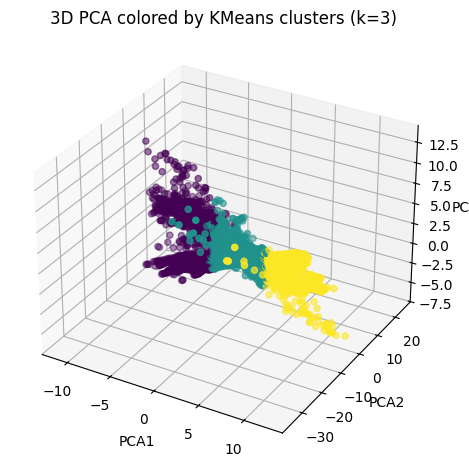

In [ ]:
# clustering_countries_3d_pca.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (ensures 3D proj is registered)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# ---- 1) Load data ----
df = pd.read_excel("data.xlsx")  # make sure data.xlsx is in the same folder
df = df.drop('year', axis=1)

# Identify a country/name column for labels (optional)
possible_name_cols = [c for c in df.columns if str(c).lower() in ["country","country_name","name","nation"]]
name_col = possible_name_cols[0] if possible_name_cols else (df.columns[0] if not pd.api.types.is_numeric_dtype(df.iloc[:,0]) else None)

# ---- 2) Numeric features ----
X_num = df.select_dtypes(include=[np.number]).copy()
if X_num.shape[1] == 0:
    raise ValueError("No numeric columns were found for clustering.")

# ---- 3) Impute + scale ----
imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X_num.values)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# ---- 4) Quick elbow to pick k ----
def pick_k_by_elbow(X, ks=(2,3,4,5,6)):
    inertias = []
    for k in ks:
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        km.fit(X)
        inertias.append(km.inertia_)
    drops = [(inertias[i-1]-inertias[i])/inertias[i-1] for i in range(1, len(inertias))]
    if drops:
        best_idx = int(np.argmax(drops)) + 1
        return ks[best_idx]
    return ks[0]

k = pick_k_by_elbow(X_scaled)

# ---- 5) Cluster ----
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# ---- 6) PCA with 3 components ----
pca3 = PCA(n_components=3, random_state=42)
X_pca3 = pca3.fit_transform(X_scaled)
print("3D PCA explained variance ratios:", pca3.explained_variance_ratio_)

# ---- 7) Save results ----
ids = df[name_col] if name_col else pd.RangeIndex(start=1, stop=len(df)+1, step=1)
results = pd.DataFrame({
    "ID": ids,
    "Cluster": labels,
    "PCA1": X_pca3[:, 0],
    "PCA2": X_pca3[:, 1],
    "PCA3": X_pca3[:, 2],
})
results.to_csv("country_clusters_3d.csv", index=False)
print("Saved 3D cluster assignments to country_clusters_3d.csv")

# ---- 8) 3D scatter plot ----
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2], c=labels)  # default colormap

ax.set_title(f"3D PCA colored by KMeans clusters (k={k})")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")

# Optional: light annotation if few points (<= 30) to avoid clutter
if len(results) <= 30:
    for i, txt in enumerate(results["ID"].astype(str).values):
        ax.text(X_pca3[i, 0], X_pca3[i, 1], X_pca3[i, 2], txt, fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
# clustering_countries_3d_interactive.py
# pip install plotly scikit-learn pandas openpyxl

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px

# ---- 1) Load data ----
df = pd.read_excel("data.xlsx")  # ensure data.xlsx is in the same folder

# Guess a country/name column (used for hover labels)
possible_name_cols = [c for c in df.columns if str(c).lower() in ["country","country_name","name","nation"]]
name_col = possible_name_cols[0] if possible_name_cols else (
    df.columns[0] if not pd.api.types.is_numeric_dtype(df.iloc[:,0]) else None
)
ids = df[name_col] if name_col else pd.RangeIndex(start=1, stop=len(df)+1, step=1)

# ---- 2) Numeric features ----
X_num = df.select_dtypes(include=[np.number]).copy()
if X_num.shape[1] == 0:
    raise ValueError("No numeric columns were found for clustering.")

# ---- 3) Impute + scale ----
imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X_num.values)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# ---- 4) Quick elbow to pick k ----
def pick_k_by_elbow(X, ks=(2,3,4,5,6)):
    inertias = []
    for k in ks:
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        km.fit(X)
        inertias.append(km.inertia_)
    drops = [(inertias[i-1]-inertias[i])/inertias[i-1] for i in range(1, len(inertias))]
    if drops:
        best_idx = int(np.argmax(drops)) + 1  # index into ks
        return ks[best_idx]
    return ks[0]

k = pick_k_by_elbow(X_scaled)

# ---- 5) Cluster ----
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# ---- 6) PCA with 3 components (for visualization only) ----
pca3 = PCA(n_components=3, random_state=42)
X_pca3 = pca3.fit_transform(X_scaled)

# ---- 7) Build output table ----
out = pd.DataFrame({
    "ID": ids,
    "Cluster": labels,
    "PCA1": X_pca3[:,0],
    "PCA2": X_pca3[:,1],
    "PCA3": X_pca3[:,2],
})
# Include some original features in hover (limit to first ~8 to keep tooltips readable)
hover_cols = list(X_num.columns[:8])
out = pd.concat([out, df[hover_cols].reset_index(drop=True)], axis=1)
out.to_csv("country_clusters_3d_interactive.csv", index=False)
print(f"Saved CSV -> country_clusters_3d_interactive.csv  (k={k})")
print("3D PCA explained variance:", pca3.explained_variance_ratio_)

# ---- 8) Interactive 3D plot ----
fig = px.scatter_3d(
    out,
    x="PCA1", y="PCA2", z="PCA3",
    color="Cluster",
    hover_name="ID",
    hover_data=hover_cols,  # extra features on hover
    title=f"Interactive 3D PCA of Countries (K-Means k={k})"
)
# nicer marker size and legend
fig.update_traces(marker=dict(size=6))
fig.update_layout(legend_title_text="Cluster", margin=dict(l=10, r=10, t=40, b=10))

# Show in notebook:
fig.show()

# Save a standalone HTML (double-click to open in a browser)
fig.write_html("country_clusters_3d_interactive.html", include_plotlyjs="cdn")
print("Saved HTML -> country_clusters_3d_interactive.html")


Saved CSV -> country_clusters_3d_interactive.csv  (k=3)
3D PCA explained variance: [0.36080054 0.08836956 0.07687028]


Saved HTML -> country_clusters_3d_interactive.html


In [ ]:
# analyze_cluster_drivers.py
# pip install scikit-learn pandas numpy statsmodels

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif
from statsmodels.stats.multitest import multipletests

# ------------ Load + prep (safe to rerun) ------------
df = pd.read_excel("data.xlsx")

# Find label column for display (optional)
possible_name_cols = [c for c in df.columns if str(c).lower() in ["country","country_name","name","nation"]]
name_col = possible_name_cols[0] if possible_name_cols else (
    df.columns[0] if not pd.api.types.is_numeric_dtype(df.iloc[:,0]) else None
)
ids = df[name_col] if name_col else pd.RangeIndex(start=1, stop=len(df)+1, step=1)

# Numeric features
X_num = df.select_dtypes(include=[np.number]).copy()
if X_num.shape[1] == 0:
    raise ValueError("No numeric columns for analysis.")

# Impute + scale
imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(X_num.values)
sc = StandardScaler()
X_scaled = sc.fit_transform(X_imp)

# Cluster if you don't already have labels
k = 3 if X_scaled.shape[0] >= 3 else max(2, X_scaled.shape[0])
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Optional: PCA (useful for loadings)
pca = PCA(n_components=min(5, X_scaled.shape[1]), random_state=42)
pca.fit(X_scaled)

# ------------ 1) Cluster centroids & z-score profiles ------------
# Centroids in standardized space (mean z-score per cluster)
centroids_z = []
for c in range(k):
    centroids_z.append(X_scaled[labels == c].mean(axis=0))
centroids_z = np.vstack(centroids_z)  # k x p
centroids_z_df = pd.DataFrame(centroids_z, columns=X_num.columns, index=[f"Cluster {c}" for c in range(k)])

# Also give centroids in original units (inverse transform of z-centroids)
centroids_orig = sc.inverse_transform(centroids_z)  # back to original feature space
# Removed the line that caused the error: centroids_orig = imp.inverse_transform(centroids_orig) if hasattr(imp, "inverse_transform") else centroids_orig
centroids_orig_df = pd.DataFrame(centroids_orig, columns=X_num.columns, index=[f"Cluster {c}" for c in range(k)])

# Rank the top drivers per cluster (largest |z| per cluster)
top_n = 8
top_features_per_cluster = {}
for c in range(k):
    z = centroids_z_df.loc[f"Cluster {c}"].abs().sort_values(ascending=False)
    top_features_per_cluster[f"Cluster {c}"] = list(z.index[:top_n])

# ------------ 2) Global ANOVA across clusters ------------
F, p = f_classif(X_scaled, labels)
anova_df = pd.DataFrame({"feature": X_num.columns, "F": F, "p_raw": p})
# Benjamini–Hochberg FDR correction
anova_df["p_fdr"] = multipletests(anova_df["p_raw"], alpha=0.05, method="fdr_bh")[1]
anova_df.sort_values(["p_fdr","F"], ascending=[True, False], inplace=True)

# ------------ 3) One-vs-rest linear model importances ------------
# Fit multinomial logistic regression on standardized features
logreg = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    C=1.0,
    max_iter=200,
    random_state=42
)
logreg.fit(X_scaled, labels)

# Coefficients: shape (k, p). Larger positive = pushes toward that class.
coef_df = pd.DataFrame(logreg.coef_, columns=X_num.columns, index=[f"Cluster {c}" for c in range(k)])
# For each cluster, show top positive/negative contributors
top_pos_neg = {}
for c in range(k):
    s = coef_df.loc[f"Cluster {c}"]
    top_pos = s.sort_values(ascending=False).head(top_n)
    top_neg = s.sort_values(ascending=True).head(top_n)
    top_pos_neg[f"Cluster {c}"] = {
        "top_positive": top_pos.index.tolist(),
        "top_negative": top_neg.index.tolist()
    }

# ------------ 4) PCA loadings (for the plotted axes) ------------
# Loadings: how each original feature contributes to PC1/PC2/PC3...
loadings = pd.DataFrame(
    pca.components_.T,
    index=X_num.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
).sort_index()

# ------------ Save summaries ------------
centroids_z_df.to_csv("cluster_centroids_zscores.csv")
centroids_orig_df.to_csv("cluster_centroids_original_units.csv")
anova_df.to_csv("feature_anova_fdr.csv", index=False)
coef_df.to_csv("logreg_one_vs_rest_coefficients.csv")
loadings.to_csv("pca_loadings.csv")

# ------------ Print quick digest ------------
print(f"\nTop |z| features per cluster (n={top_n}):")
for c, feats in top_features_per_cluster.items():
    print(f"- {c}: {feats}")

print("\nMost significant global separators (ANOVA, FDR<=0.05):")
sig = anova_df[anova_df["p_fdr"] <= 0.05].head(20)
print(sig[["feature","F","p_fdr"]])

print("\nStrongest logistic coefficients per cluster (top +/-):")
for c, d in top_pos_neg.items():
    print(f"- {c}  + {d['top_positive']}  |  - {d['top_negative']}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.




Top |z| features per cluster (n=8):
- Cluster 0: ['Gross National Income Per Capita, female (2021 PPP$)', 'Gross National Income Per Capita, male (2021 PPP$)', 'Gross National Income Per Capita (2021 PPP$)', 'Material footprint per capita (tonnes)', 'Difference from HDI value (%)', 'Gender Inequality Index (value)', 'HDI male', 'Human Development Index (value)']
- Cluster 1: ['Human Development Index (value)', 'Mean Years of Schooling, female (years)', 'Mean Years of Schooling (years)', 'Life Expectancy at Birth, female (years)', 'Life Expectancy at Birth (years)', 'Expected Years of Schooling, female (years)', 'Mean Years of Schooling, male (years)', 'Planetary pressures–adjusted Human Development Index (value)']
- Cluster 2: ['Planetary pressures–adjusted Human Development Index (value)', 'Maternal Mortality Ratio (deaths per 100,000 live births)', 'Gross National Income Per Capita, female (2021 PPP$)', 'Gross National Income Per Capita, male (2021 PPP$)', 'Gross National Income Per

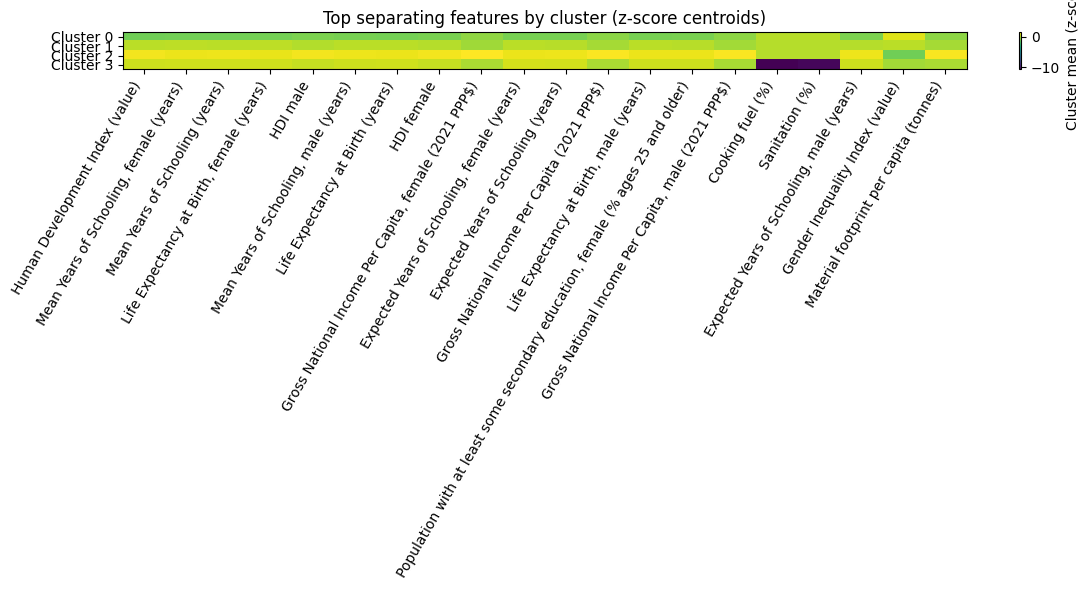

In [ ]:
# heatmap_centroids.py
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Reuse from your pipeline:
# df, X_num, X_scaled, labels, sc, k already defined
# If not, run your prep first.

# Centroids in standardized space
centroids_z = np.vstack([X_scaled[labels==c].mean(axis=0) for c in range(k)])
centroids_z_df = pd.DataFrame(centroids_z, columns=X_num.columns, index=[f"Cluster {c}" for c in range(k)])

# Load your ANOVA table to pick top features (or compute quickly here)
# anova_df has columns: feature, F, p_fdr
anova_df = pd.read_csv("feature_anova_fdr.csv")
top_feats = anova_df.sort_values(["p_fdr","F"], ascending=[True, False]).head(20)["feature"].tolist()

M = centroids_z_df[top_feats].copy()

plt.figure(figsize=(12, 6))
im = plt.imshow(M.values, aspect="auto")
plt.colorbar(im, label="Cluster mean (z-score)")
plt.xticks(range(len(top_feats)), top_feats, rotation=60, ha="right")
plt.yticks(range(k), [f"Cluster {c}" for c in range(k)])
plt.title("Top separating features by cluster (z-score centroids)")
plt.tight_layout()
plt.show()


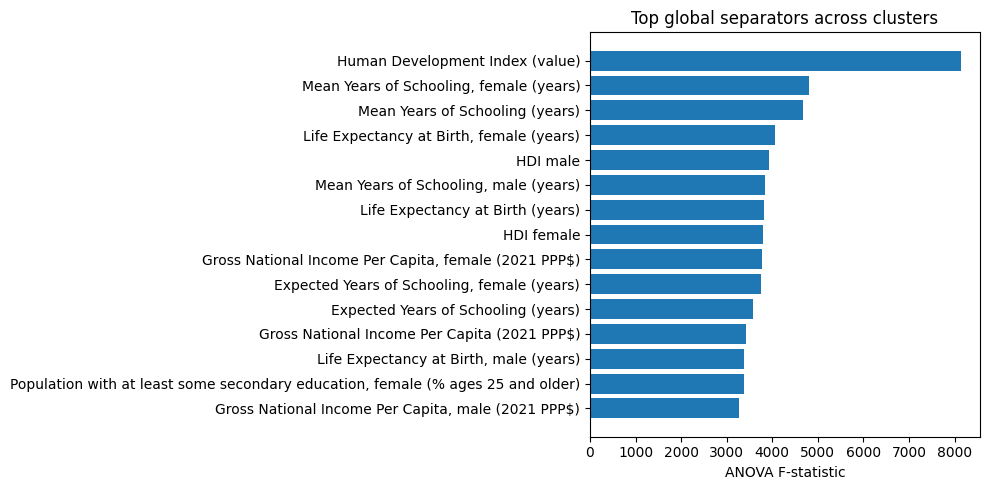

In [ ]:
# bar_anova.py
import numpy as np, pandas as pd, matplotlib.pyplot as plt

anova_df = pd.read_csv("feature_anova_fdr.csv")
top = anova_df.sort_values(["p_fdr","F"], ascending=[True, False]).head(15)

plt.figure(figsize=(10,5))
plt.barh(top["feature"][::-1], top["F"][::-1])
plt.xlabel("ANOVA F-statistic")
plt.title("Top global separators across clusters")
plt.tight_layout()
plt.show()
